# Models 
First with torch

Later from scratch

## Model with Torch

In [1]:
# initialize libs
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

# torch libs
import torch
import torch.nn as nn 
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

# load data libs
import requests
import gzip
import os
import hashlib


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/erirosv/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# getting the data to train the model

def get_data(url):
    file_path = os.path.join('/tmp', hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(file_path):
        with open (file_path, 'rb') as f:
            data = f.read()
    else:
        with open(file_path, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype = np.uint8).copy()

In [3]:
x_train = get_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = get_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
x_test = get_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = get_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

### Model

In [4]:
class ApexNet(torch.nn.Module):
    def __init__(self) -> None:
        """
        Initialize class with an constructor and parameters
        """
        super(ApexNet, self).__init__()
        self.linear_1 = nn.Linear(784, 128, bias=False)
        self.linear_2 = nn.Linear(128, 10, bias=False)
        self.soft_max = nn.LogSoftmax(dim=1)

    def forward(self, x):
        """
        Forward pass for the model
        """
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)
        s = self.soft_max(x)
        return x

### Training

loss 0.176 accuracy 0.961: 100%|██████████| 1000/1000 [00:01<00:00, 674.19it/s]


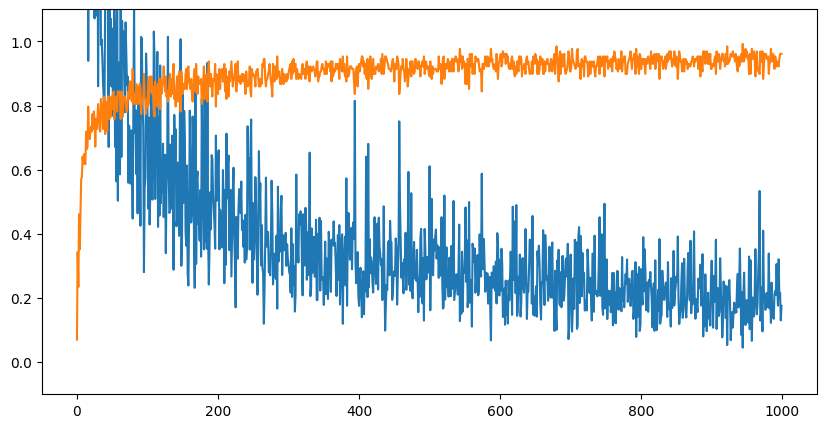

In [49]:
model = ApexNet()

# loss function
#loss_funtion = nn.NLLLoss(reduction='none')
loss_funtion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

# batch size
batch_size = 128

# empty lists for loss and accuracy
losses = []
accuracies = []

# loop to train the mdodel
for i in (t := trange(1000)):
    # creating a sample of random ints
    sample = np.random.randint(0, x_train.shape[0], size=(batch_size))
    
    # loading data into variable X and Y
    X = torch.tensor(x_train[sample].reshape((-1, 28*28))).float()
    Y = torch.tensor(y_train[sample]).long()
    
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)

    # getting the accuracy
    accuracy = (cat == Y).float().mean()

    # getting loss
    loss = loss_funtion(out, Y)
    loss = loss.mean()
    loss.backward()

    # optimizer - execute step by step
    optimizer.step()

    # getting loss and accuracy and appending them to list repectivly
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)

    # printing result
    t.set_description("loss %.3f accuracy %.3f" % (loss, accuracy))
    
# printing the data
figsize(10,5)
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)


100%|██████████| 1000/1000 [00:00<00:00, 2155.20it/s]

[2.3366293907165527, 2.2924318313598633, 2.3278191089630127, 2.3203535079956055, 2.3311831951141357, 2.294801712036133, 2.3141603469848633, 2.343644857406616, 2.3321123123168945, 2.3143885135650635, 2.323564052581787, 2.339460611343384, 2.3340790271759033, 2.3110616207122803, 2.3115530014038086, 2.326152801513672, 2.3371760845184326, 2.329209089279175, 2.3104846477508545, 2.337273359298706, 2.333096742630005, 2.3035783767700195, 2.314707040786743, 2.3339755535125732, 2.2919492721557617, 2.344654083251953, 2.2967607975006104, 2.344367504119873, 2.340643882751465, 2.3141188621520996, 2.3513436317443848, 2.318084955215454, 2.3569321632385254, 2.3267300128936768, 2.317253351211548, 2.325073480606079, 2.326604127883911, 2.2993860244750977, 2.30778431892395, 2.3365869522094727, 2.345546007156372, 2.3113086223602295, 2.305210590362549, 2.3353569507598877, 2.3205149173736572, 2.3333017826080322, 2.3391435146331787, 2.3375699520111084, 2.3088881969451904, 2.3319032192230225, 2.3040897846221924,

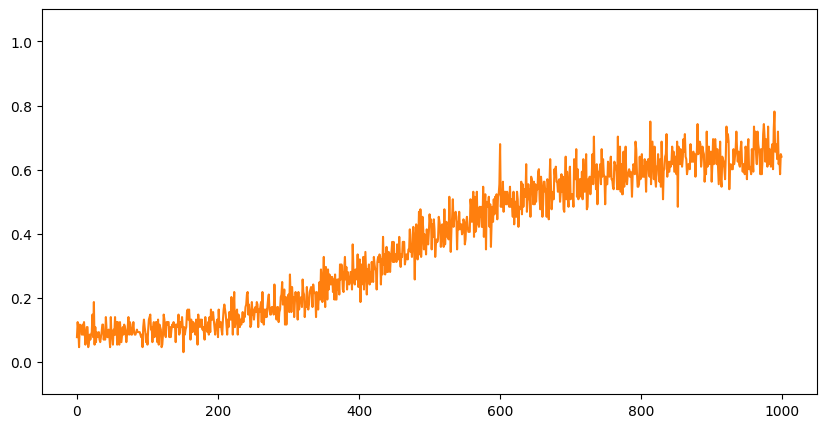

In [60]:
# optimized model with torch
model = ApexNet()
loss_funtion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001, momentum=0)
batch_size = 128
losses, accuracies = [], []

mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std

for i in trange(1000):
    sample = np.random.randint(0, x_train.shape[0], size=batch_size)
    X, Y = map(torch.tensor, (x_train[sample].reshape(-1, 28*28), y_train[sample]))
    out = model(X.float())
    loss = loss_funtion(out, Y.long())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    accuracies.append((torch.argmax(out, dim=1) == Y).float().mean().item())
    t.set_description(f"loss {losses[-1]:.3f} accuracy {accuracies[-1]:.3f}")

print(losses)
figsize(10,5)
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)


### Evaluation

In [6]:
Y_test_predictions = torch.argmax(model(torch.tensor(x_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(y_test == Y_test_predictions).mean()

0.9309

### Breakdown of gradients 

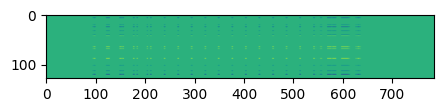

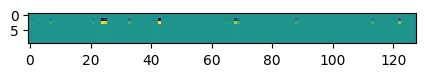

In [7]:
samp = [1,2,3,]
model.zero_grad()
out = model(torch.tensor(x_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()

loss = loss_funtion(out, torch.tensor(y_test[samp]).long()).mean()
loss.backward()

imshow(model.linear_1.weight.grad)
figure()
imshow(model.linear_2.weight.grad)

## Model from scratch here

In [8]:
# making the sam layer from torch with numpy
layer_1 = np.zeros((784, 128), dtype=np.float32)
layer_2 = np.zeros((128, 10), dtype=np.float32)

# checking the types
(layer_1.dtype, layer_2.dtype)

(dtype('float32'), dtype('float32'))

In [9]:
# checking memory address for layer_1 and layer_2
(id(layer_1), id(layer_2))

(6076831952, 6399792880)

In [10]:
# used stupid name for layer in torch model
# copy weight from torch model
layer_1[:] = model.linear_1.weight.detach().numpy().T
layer_2[:] = model.linear_2.weight.detach().numpy().T

In [11]:
# forward-pass in numpy
def forward(x):
    x = x.dot(layer_1)
    x = np.maximum(x, 0)
    x = x.dot(layer_2)
    return x

In [12]:
Y_test_predictions_out = forward(x_test.reshape((-1, 28*28)))
Y_test_predictions = np.argmax(Y_test_predictions_out, axis=1)
(y_test == Y_test_predictions).mean()

0.9309

### Training (numpy)

In [13]:
#ret = (-np.array([Y_test_predictions_out[i, y_test[i]] for i in range(Y_test_predictions_out.shape[0])]) 
#       + np.log(np.exp(Y_test_predictions_out).sum(axis=1)))

ret = (-Y_test_predictions_out[range(Y_test_predictions_out.shape[0]), y_test] 
       + np.log(np.exp(Y_test_predictions_out).sum(axis=1)))

#plot(ret)

In [14]:
#np.gradient()

In [15]:
# test show classified img
#imshow(x_test[3508])

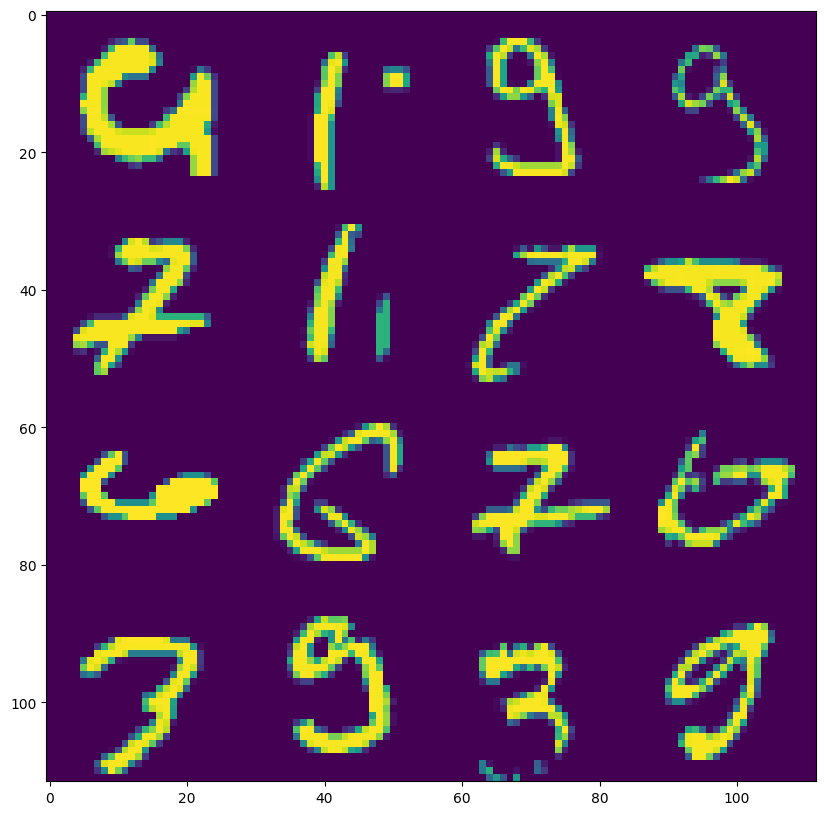

In [16]:
# grid
grid_var = 4
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=True)[0:grid_var*grid_var]
temp = x_test[[x[1] for x in grid]]

figsize(10,10)
imshow(np.concatenate(temp.reshape((grid_var, 28*grid_var, 28)), axis=1))

In [17]:
sample = 1
-Y_test_predictions_out[sample, y_test[0]] + np.log(np.exp(Y_test_predictions_out[sample]).sum())

19.784832

In [18]:
-np.array([Y_test_predictions_out[i, y_test[i]] for i in range(Y_test_predictions_out.shape[0])]) + np.log(np.exp(Y_test_predictions_out).sum(axis=1))

array([0.00000286, 0.07444   , 0.00021744, ..., 0.00003624, 0.003479  ,
       0.00000381], dtype=float32)

In [19]:
Y_test_predictions_out[:, y_test].shape

(10000, 10000)

In [20]:
Y_test_predictions_out[y_test.reshape((1,-1))].shape

(1, 10000, 10)

In [21]:
np.array([Y_test_predictions_out[i, y_test[i]] for i in range(Y_test_predictions_out.shape[0])])

array([14.954415, 10.269101, 14.505413, ..., 12.433897, 16.333488,
       15.031289], dtype=float32)

(1, 784) (1, 128) (1, 128) (1, 10)
(128, 10) (1, 128)


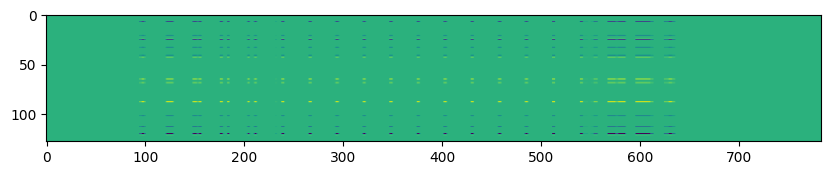

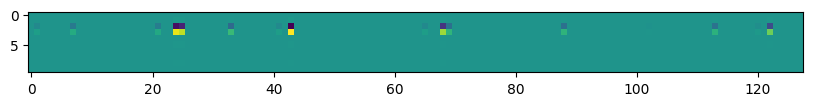

In [44]:
# forward pass
x = x_test[1:2].reshape((-1, 28*28))
x_layer_1 = x.dot(layer_1)
x_relu = np.maximum(x_layer_1, 0)
x_layer_2 = x_relu.dot(layer_2)
# check the shapes of the layers
print(x.shape, x_layer_1.shape, x_relu.shape, x_layer_2.shape)

# backward pass (testing)
out = np.zeros((1,10), np.float32)
out[0,2] = 1
#out = torch.tensor(out)

# derivated: log_softmax
#gradient_in = torch.tensor(Y_test_predictions_out[1], requires_grad=True)
out = torch.tensor(out)
gradient_in = torch.tensor(x_layer_2, requires_grad=True)
gradient_out = torch.nn.functional.log_softmax(gradient_in, dim=1)
loss = (-out * gradient_out).mean()
loss.backward()
dx_sm = gradient_in.grad.numpy()

# derivated (d): linera_2
d_layer2 = x_relu.T.dot(dx_sm)
dx_relu = dx_sm.dot(layer_2.T)

# derivate: ReLu (chainrule)
dx_layer1 = (x_relu > 0).astype(np.float32) * dx_relu

#derivate: layer 1
d_layer1 = x.T.dot(dx_layer1)

print(d_layer2.shape, dx_relu.shape)
imshow(d_layer1.T)
figure()
imshow(d_layer2.T)


In [38]:
(dx_relu > 0).astype(np.float32)

array([[0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
        0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.]],
      dtype=float32)